In [1]:
import argparse
import logging
from lzma import PRESET_DEFAULT
import os
import sys
from xml.etree.ElementPath import prepare_descendant

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from model import AttU_Net
from model import U_Net
from model import NestedUNet
from utils.loss_function import *
from utils.accuracy import *
from utils.dataset import *
from utils.array import *
from scipy import interpolate

from torch.utils.tensorboard import SummaryWriter
from utils.dataset import TrainingDataset
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image, ImageFilter
from collections import OrderedDict

from pathlib import Path
import skimage
from skimage.morphology import thin, skeletonize
from glob import glob

matplotlib.rcParams['figure.figsize'] = [40, 40]

# Define your source files
# raw_folder = "/mnt/external.data/TowbinLab/spsalmon/bacteria_database/validation_set/raw/"
# bodysegmentation_folder = '/mnt/external.data/TowbinLab/spsalmon/bacteria_database/validation_set/body_seg/'


raw_folder = "/mnt/external.data/TowbinLab/spsalmon/shallow_chambers_database/validation_set/raw/"
bodysegmentation_folder = '/mnt/external.data/TowbinLab/spsalmon/shallow_chambers_database/validation_set/body_seg/'
def make_prediction(net,
                np_array,
                device,
                dim = 512,
                binary = True):
    
    # Preprocess on the image
    img = torch.from_numpy(TrainingDataset.preprocess_img_or_msk(np_array, dim))
    print(img.shape)
    img = img.unsqueeze(0).to(device=device, dtype=torch.float32)
    print(img.shape)

    # Work on the 
    with torch.no_grad():
        output = net(img)
        # output = output+((output>0)*100)
        if binary:
            return torch.sigmoid(output) > 0.5, output
            # return torch.round(torch.sigmoid(output)), output
            # return torch.round(torch.sigmoid(output)), torch.sigmoid(output)
        else:
            return torch.softmax(output, dim=1)

def resize_pred_binary(pred, shape):
    pred = pred.squeeze(0).cpu().numpy()
    print(shape)
    print(pred.shape)
    x, y, z = pred.shape[0], pred.shape[1], pred.shape[2]

    return ndimage.zoom(pred, (x, shape[0] / y, shape[1] / z), order=1)

def load_model(model_path, n_classes):
    # Load U-Net
    # net = UNet(n_channels = 2, n_classes = n_classes)
    # Load NestedUNET
    net = AttU_Net(n_channels=2, n_classes=n_classes)
    # net = U_Net(n_channels=1, n_classes=n_classes)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(model_path, map_location=device)
    net.to(device=device)

    state_dict = checkpoint['model_state_dict']
    # create new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    # load params
    
    net.load_state_dict(new_state_dict)

    # print("Model : epoch = %s | accuracy = %s" % (checkpoint['epoch'], checkpoint['IoU_val']))
    print(checkpoint.keys())

    return {'net': net, 'device':device, 'epoch':checkpoint['epoch']}

def readImages(fn):
    raw_filelist = sorted(os.listdir(raw_folder))
    raw_file = raw_filelist[fn]
    list_time_point = (raw_file.split("_"))[0:2]
    time_point = "_".join(list_time_point)
    print(time_point)
    # body_file = glob(bodysegmentation_folder + "seg_" + time_point + '*')[0]
    body_file = glob(bodysegmentation_folder + time_point + '*')[0]

    if os.path.exists(os.path.join(bodysegmentation_folder, body_file)):
        raw_image = ti.imread(os.path.join(raw_folder, raw_file))
        body_seg = ti.imread(os.path.join(bodysegmentation_folder, body_file))

        transparency = raw_image

        return transparency, body_seg

def treatMask(mask, filter_size):
    smoothed_mask = Image.fromarray(mask)
    smoothed_mask = smoothed_mask.filter(ImageFilter.ModeFilter(size=filter_size))
    smoothed_mask = np.asarray(smoothed_mask)

    # a, labels = cv2.connectedComponents(smoothed_mask)
    # unique, counts = np.unique(labels, return_counts=True)
    # worm_label = np.argwhere(counts == np.unique(counts)[-2])[0][0]

    # new_mask = labels == worm_label

    return smoothed_mask

def getWormLength(mask):
    lsp = skeletonize(mask)
    pixellist = np.argwhere(lsp)
    wormlength = np.shape(pixellist)[0]

    return wormlength

def getSpline(im, spacing, overedge, strwidth):
    a, labels = cv2.connectedComponents(im)
    unique, counts = np.unique(labels, return_counts=True)
    worm_label = np.argwhere(counts == np.unique(counts)[-2])[0][0]

    lsp = skeletonize(labels == worm_label)
    pixellist = np.argwhere(lsp)
    wormlength = np.shape(pixellist)[0]
    anchorlist = pixellist[0:wormlength:spacing, :]
    nsplinePoints = wormlength*2

    x = anchorlist[:, 0]
    y = anchorlist[:, 1]

    nNodes = anchorlist.shape[0]
    nodePositions = np.zeros((nNodes,))
    lastNodePosition = 0
    for i in range(1, nNodes):
        dx = x[i] - x[i-1]
        dy = y[i] - y[i-1]

        dLength = np.sqrt(dx*dx + dy*dy)

        if dLength < 0.001:
            dLength = 0.001
        
        lastNodePosition = lastNodePosition + dLength
        nodePositions[i] = lastNodePosition
    space = np.linspace(-overedge,lastNodePosition+overedge,nsplinePoints)
    
    x_tck = interpolate.splrep(nodePositions, x, s=0)
    xs = interpolate.splev(space, x_tck, der = 0)

    y_tck = interpolate.splrep(nodePositions, y, s=0)
    ys = interpolate.splev(space, y_tck, der = 0)

    shape = np.zeros((xs.shape[0], 2))
    shape[:, 0] = xs
    shape[:, 1] = ys

    strwidth = strwidth - 1

    xsize = im.shape[0]
    ysize = im.shape[1]

    pixl1 = xs
    pixl2 = ys

    iminp2 = np.zeros((xsize + 2*strwidth))


    return [xs, ys]

def computeWormVolume(mask):
    worm_pixels = np.count_nonzero(mask)
    total_image_size = mask.flatten().shape[0]
    worm_ratio = worm_pixels/total_image_size
    return(worm_ratio)

def IoU(pred, mask):
    # worm prediction IoU score
    num = np.sum(pred*mask)
    denum = np.sum(pred + mask - (pred*mask))
    worm_score = num/denum

    #background prediction IoU score
    pred = (1-pred)
    mask = (1-mask)
    num = np.sum(pred*mask)
    denum = np.sum(pred + mask - (pred*mask))
    background_score = num/denum
    return (worm_score + background_score)/2

In [2]:
net = load_model("./checkpoints/CP_epoch29.pth", 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

raw, body_seg = readImages(5359)
print(raw.shape)

pred, uncertainty_map = make_prediction(net['net'], raw, device, dim = 1056)
pred = pred.cpu().numpy()
# pred = resize_pred_binary(pred, body_seg.shape)
# uncertainty_map = resize_pred_binary(uncertainty_map, body_seg.shape)

uncertainty_map = np.squeeze(uncertainty_map)
pred = np.squeeze(pred)
pred = pred.astype('uint8')

print(pred.shape)

dict_keys(['epoch', 'dim', 'model_state_dict', 'optimizer_state_dict', 'loss_val', 'iou_val', 'loss_train'])


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/external.data/TowbinLab/spsalmon/shallow_chambers_database/validation_set/raw/'

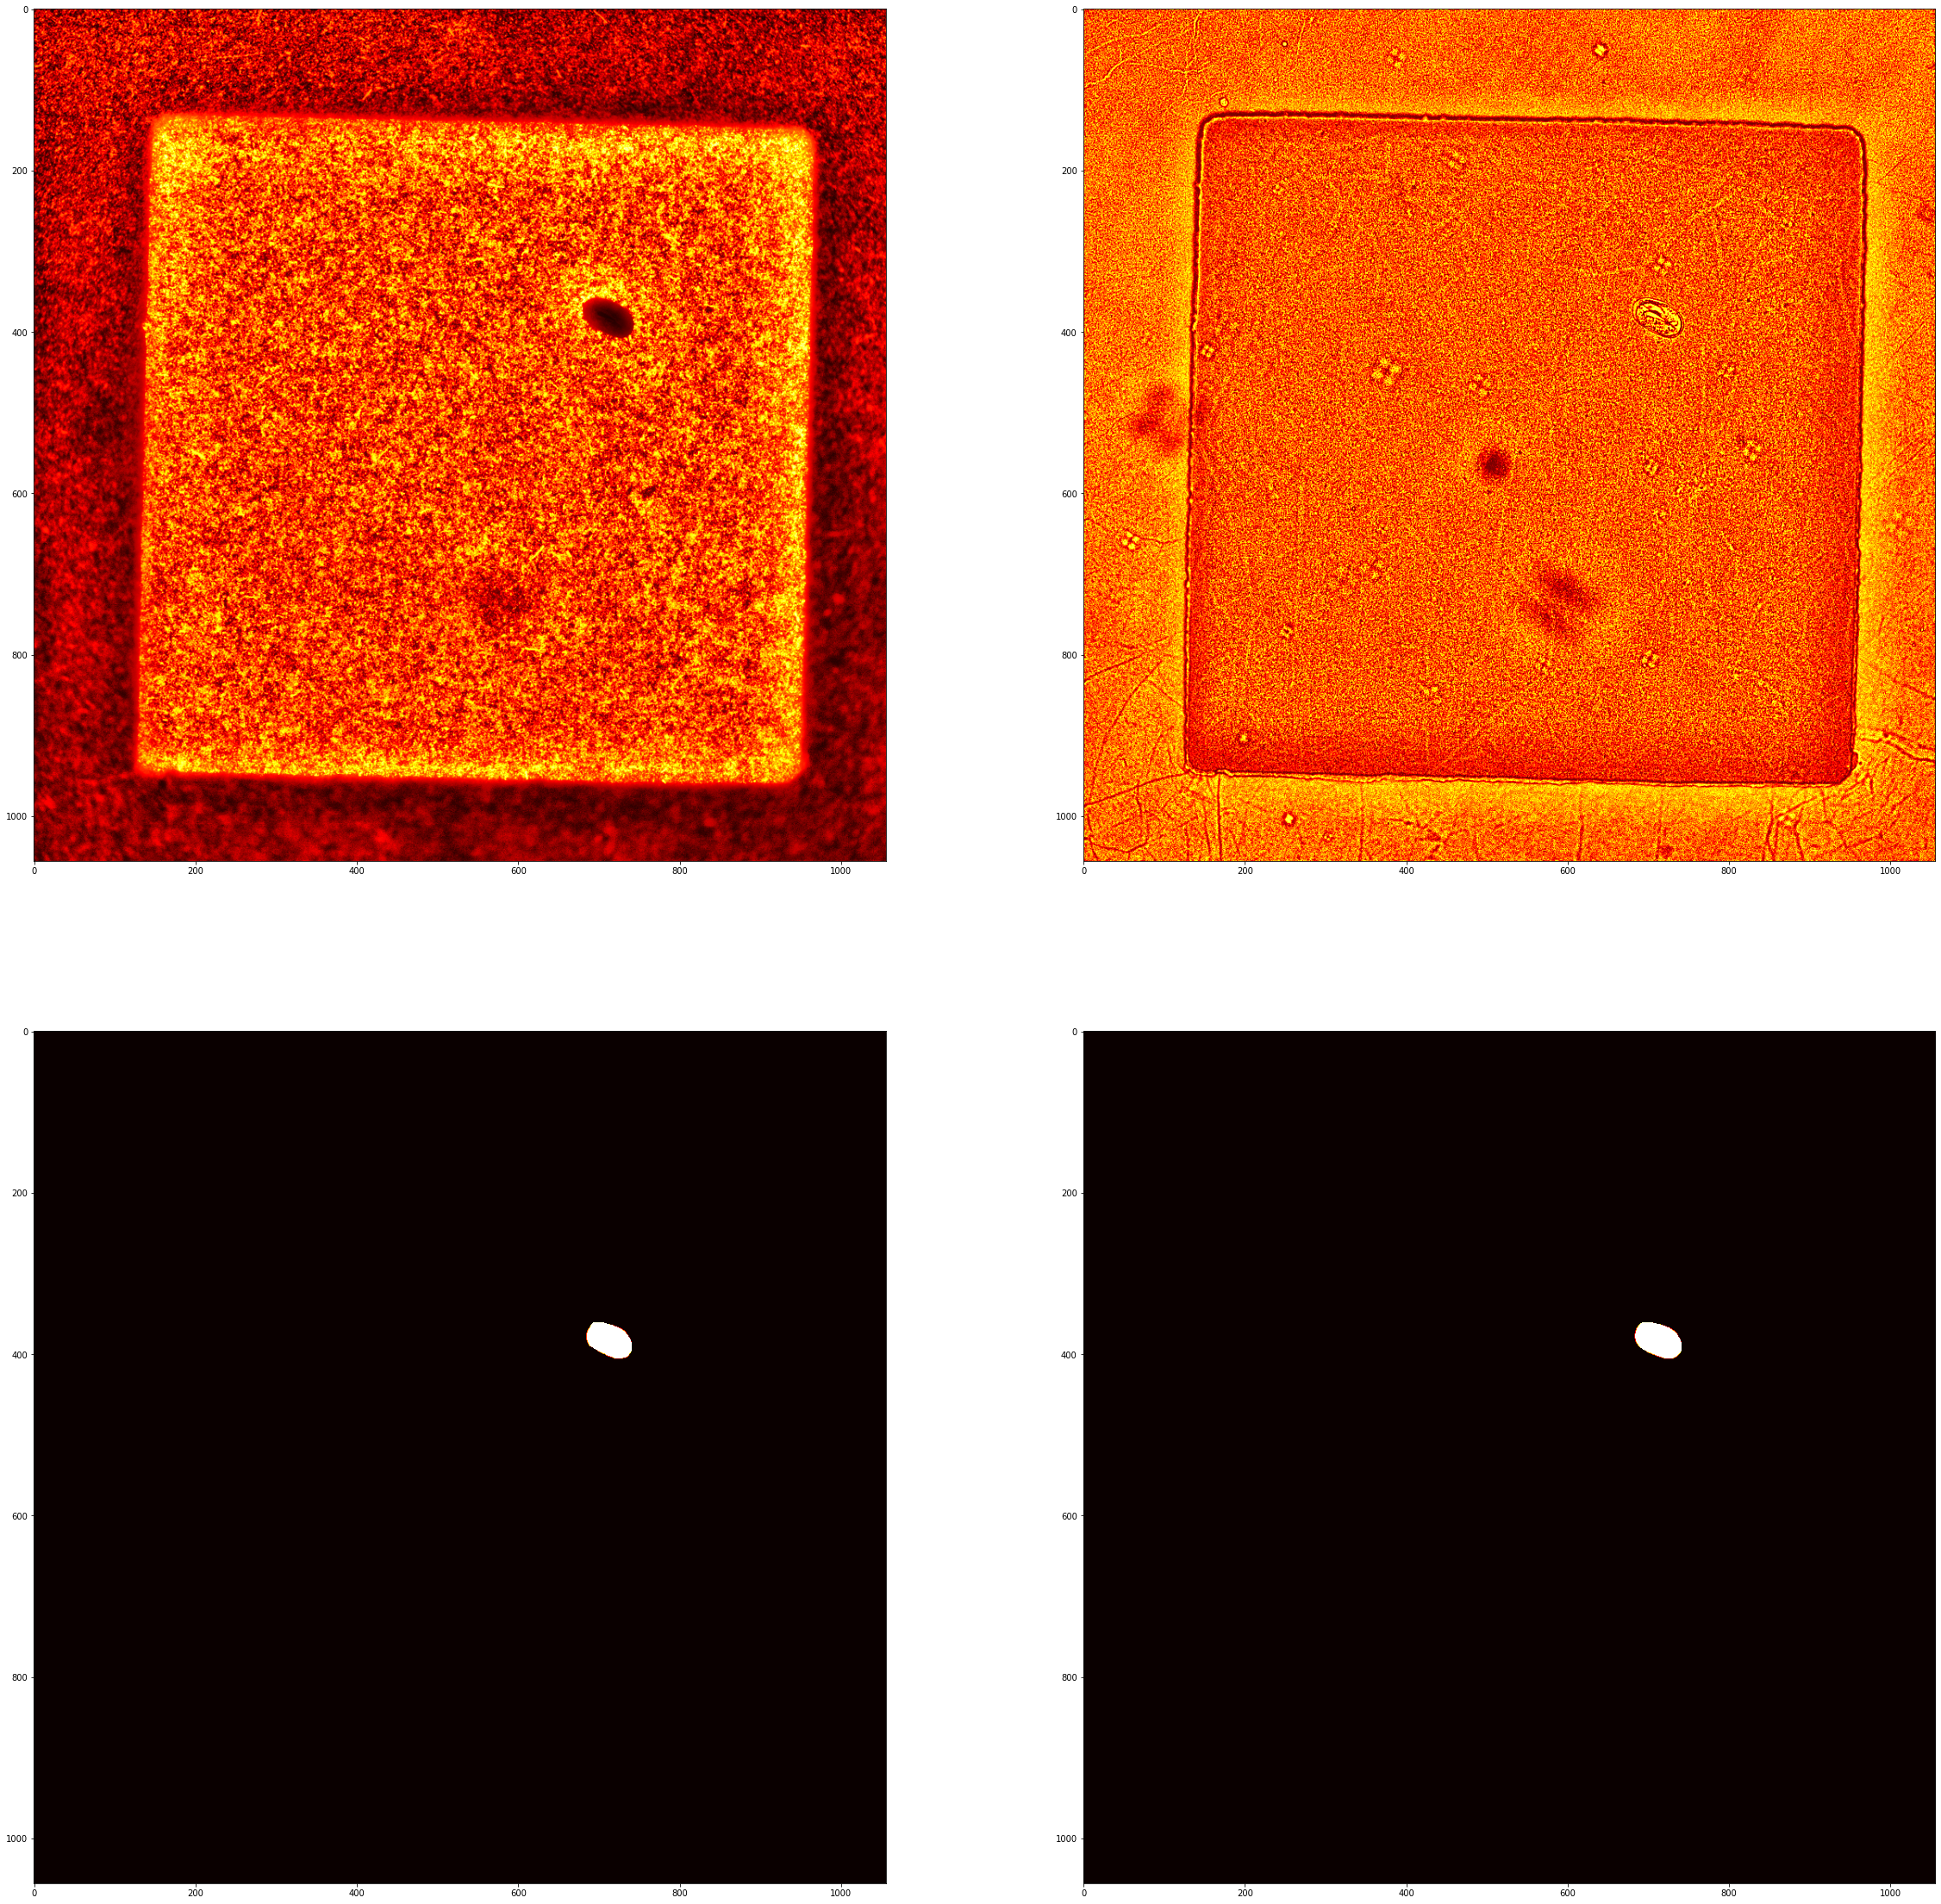

In [ ]:
fig = plt.figure()
fig.set_figheight(40)
fig.set_figwidth(40)

# raw = TrainingDataset.preprocess_img_or_msk(raw, body_seg.shape[1])
raw = TrainingDataset.preprocess_img_or_msk(raw, 1056)
body_seg = TrainingDataset.preprocess_img_or_msk(body_seg, 1056).squeeze()

fig.add_subplot(2,2,1)
ims = plt.imshow(raw[0, :, :], cmap='hot')

fig.add_subplot(2,2,2)
ims = plt.imshow(raw[1, :, :], cmap='hot')

# smoothed_pred = treatMask(pred, 4)
smoothed_pred = pred
# display the new image
fig.add_subplot(2,2,3)
imshow = plt.imshow(body_seg[:, :], cmap='hot')

fig.add_subplot(2,2,4)
imshow = plt.imshow(smoothed_pred, cmap='hot')

In [ ]:
smoothed_pred = np.expand_dims(smoothed_pred, axis = 0)
body_seg = np.expand_dims(body_seg, axis = 0)

print("accuracy (%) :", compute_segmentation_accuracy_binary(smoothed_pred, body_seg)*100)
print("IoU score :", IoU(smoothed_pred, body_seg))
print("length error (%) :", (getWormLength(smoothed_pred) - getWormLength(body_seg))/getWormLength(body_seg) * 100)
print("volume error (%) :", (computeWormVolume(smoothed_pred) - computeWormVolume(body_seg))/computeWormVolume(body_seg) * 100)

accuracy (%) : 99.86205319037684
IoU score : 0.9756854883952801
length error (%) : -5.0
volume error (%) : 4.552758435993569


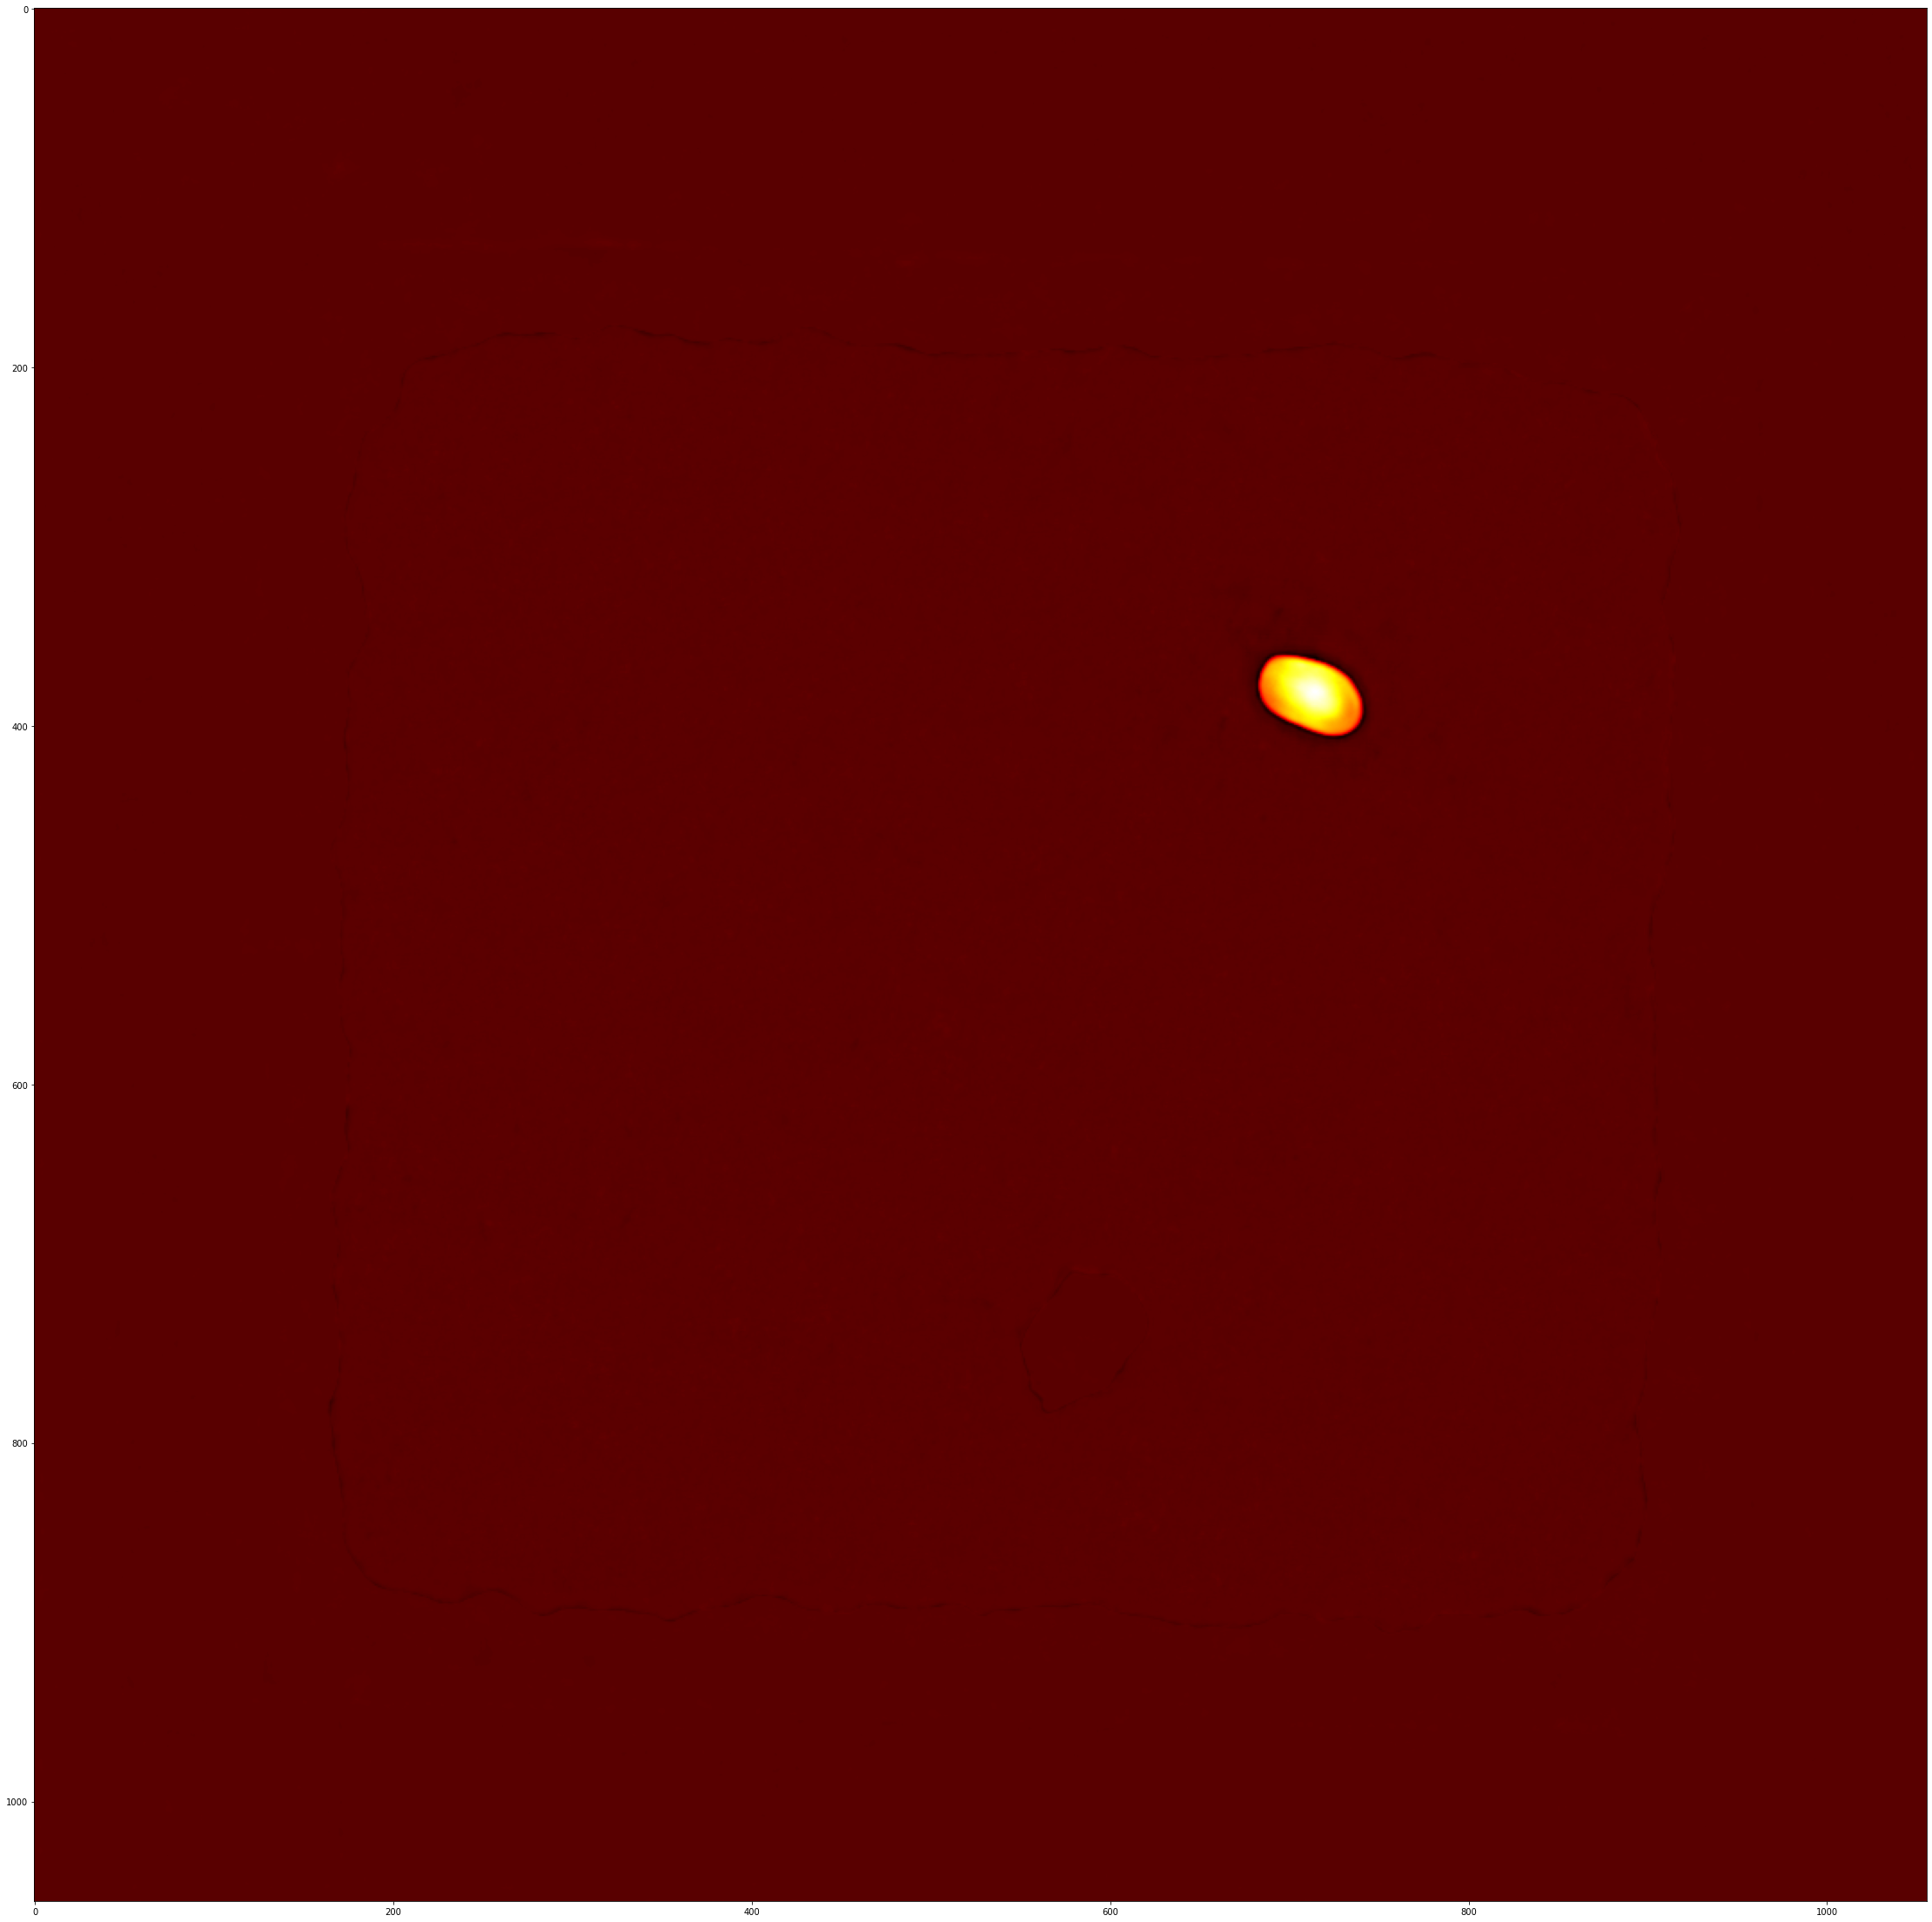

In [ ]:
plt.imshow(uncertainty_map, cmap = "hot")
plt.show()